<a href="https://colab.research.google.com/github/hufsaim/T10306201/blob/master/notebook/Lab07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain segmentation using 3D U-net 

---

- 3D u-net을 이용하여 T1 MRI로부터 brain영역에 대한 binary segmentation을 수행하는 연습을 합니다. 
- nifti format의 3D 의료영상을 편리하게 활용하기 위하여 torchio를 이용할 것입니다.
  - https://torchio.readthedocs.io/
- U-net은 2015년 Ronneberger에 의해 제안된 fully convolutional network로 의료영상 segmentation에서 널리 활용되고 있는 구조입니다. 
  - https://arxiv.org/abs/1505.04597



In [1]:
!pip install torchio
!pip install unet

In [2]:
import copy
import enum
import random
import warnings
import tempfile
import subprocess
import multiprocessing
from pathlib import Path

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM

import numpy as np
import nibabel as nib

from unet import UNet

from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

print('TorchIO version:', torchio.__version__)

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits

TorchIO version: 0.17.53


- print(device)를 통해 cuda가 출력되어 GPU를 활용할 수 있음을 확인합니다.

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cuda:0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Config
seed = 42
training_split_ratio = 0.9

### 사용할 3D의료영상 데이터의 경로를 지정하고, 구조 및 데이터셋을 정의합니다.

In [6]:
dataset_dir = Path('/your path/ixi_tiny_train')

images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'label'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

# These two names are arbitrary
MRI = 'mri'
BRAIN = 'brain'

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject_dict = {
        MRI: torchio.Image(image_path, torchio.INTENSITY),
        BRAIN: torchio.Image(label_path, torchio.LABEL),
    }
    subject = torchio.Subject(subject_dict)
    subjects.append(subject)
dataset = torchio.ImagesDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 100 subjects


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated class ImagesDataset (ImagesDataset is deprecated in v0.18.0. Use SubjectsDataset instead.).


#### image/label nifti file을 제대로 불러오는지 확인해 봅니다.

(1, 83, 44, 55)


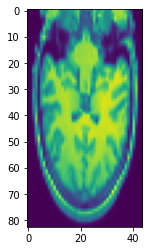

In [7]:
sample = torchio.Image(image_paths[0],torchio.INTENSITY)
I = sample.numpy()
print(I.shape)
plt.imshow(I[0,:,:,24])
plt.show()

(1, 83, 44, 55)


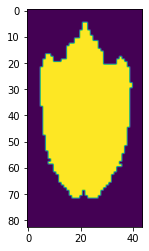

In [8]:
sample = torchio.Image(label_paths[0],torchio.LABEL)
I = sample.numpy()
print(I.shape)
plt.imshow(I[0,:,:,24])
plt.show()

### Training/Validation sets에 대한 transform 및 loader를 정의합니다.

In [9]:
training_batch_size = 8
validation_batch_size = 4

from torchio.transforms import (
    RandomAffine,
    RandomNoise,
    RescaleIntensity,
    Resample,
    ToCanonical,
    CropOrPad,
    OneOf,
    Compose,
)

training_transform = Compose([
    RescaleIntensity((0, 1)),  
    RandomNoise(),
    ToCanonical(),
    Resample((4, 4, 4)),
    CropOrPad((64, 64, 64)),
])

validation_transform = Compose([
    RescaleIntensity((0, 1)),
    ToCanonical(),
    Resample((4, 4, 4)),
    CropOrPad((64, 64, 64)),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)

training_subjects = subjects[:num_training_subjects]
validation_subjects = subjects[num_training_subjects:]

training_set = torchio.ImagesDataset(
    training_subjects, transform=training_transform)

validation_set = torchio.ImagesDataset(
    validation_subjects, transform=validation_transform)



training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=multiprocessing.cpu_count(),
)
print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 90 subjects
Validation set: 10 subjects


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated class ImagesDataset (ImagesDataset is deprecated in v0.18.0. Use SubjectsDataset instead.).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Call to deprecated class ImagesDataset (ImagesDataset is deprecated in v0.18.0. Use SubjectsDataset instead.).


### model과 loss function 등을 정의합니다.

In [10]:
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4


def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer    


def prepare_batch(batch, device):
    inputs = batch[MRI][DATA].to(device)
    foreground = batch[BRAIN][DATA].to(device)
    background = 1 - foreground
    targets = torch.cat((background, foreground), dim=CHANNELS_DIMENSION)
    return inputs, targets


def forward(model, inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        logits = model(inputs)
    return logits



def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

### train을 수행하는 함수를 정의합니다.

In [11]:
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
  
def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = forward(model, inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer)
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer)
        run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer)
#        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth') # save model

### model을 device에 할당하고 훈련을 진행합니다. 

In [12]:
model, optimizer = get_model_and_optimizer(device)

In [13]:
num_epochs=16
train(num_epochs, training_loader, validation_loader, model, optimizer,'whole_images')


Validation mean loss: 0.621
Starting epoch 1



Training mean loss: 0.468



Validation mean loss: 0.538
Starting epoch 2



Training mean loss: 0.411



Validation mean loss: 0.632
Starting epoch 3



Training mean loss: 0.380



Validation mean loss: 0.479
Starting epoch 4



Training mean loss: 0.350



Validation mean loss: 0.362
Starting epoch 5



Training mean loss: 0.320



Validation mean loss: 0.299
Starting epoch 6



Training mean loss: 0.288



Validation mean loss: 0.276
Starting epoch 7



Training mean loss: 0.256



Validation mean loss: 0.283
Starting epoch 8



Training mean loss: 0.227



Validation mean loss: 0.218
Starting epoch 9



Training mean loss: 0.201



Validation mean loss: 0.178
Starting epoch 10



Training mean loss: 0.172



Validation mean loss: 0.190
Starting epoch 11



Training mean loss: 0.147



Validation mean loss: 0.141
Starting epoch 12



Training mean loss: 0.125



Validation mean loss: 0.124
Starting epoch 13



Training mean loss: 0.106



Validation mean loss: 0.108
Starting epoch 14



Training mean loss: 0.091



Validation mean loss: 0.104
Starting epoch 15



Training mean loss: 0.080



Validation mean loss: 0.080
Starting epoch 16



Training mean loss: 0.070



Validation mean loss: 0.065


### Validation set을 이용하여 segmentation 결과를 확인해봅니다.

In [14]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
with torch.no_grad():
    outputs = forward(model, inputs)
labels = outputs.argmax(dim=CHANNELS_DIMENSION)

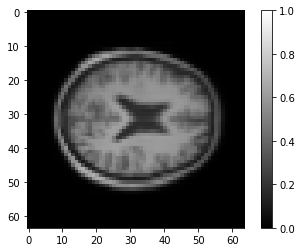

In [15]:
vn = 2
plt.imshow(inputs[vn,0,:,:,32].cpu(),vmin=0,vmax=1,cmap='gray')
plt.colorbar()
plt.show()

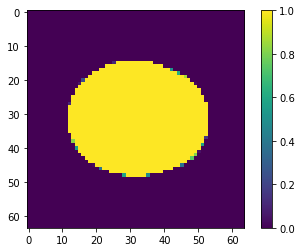

In [17]:
plt.imshow(outputs[vn,1,:,:,32].cpu(),vmin=0,vmax=1)
plt.colorbar()
plt.show()

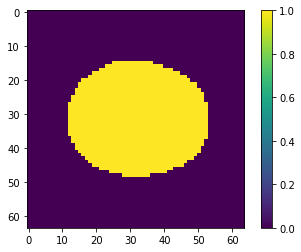

In [18]:
plt.imshow(labels[vn,:,:,32].cpu())
plt.colorbar()
plt.show()

### visualization tool을 이용해 결과를 보다 편리하게 관찰해 볼 수 있습니다.

In [19]:
!curl -sS -O https://raw.githubusercontent.com/fepegar/miccai-educational-challenge-2019/master/visualization.py

In [20]:
import visualization
plot_volume = visualization.plot_volume_interactive
%config InlineBackend.figure_format = 'retina'

In [21]:
plot_volume(inputs[vn].cpu().numpy().squeeze())

Output()

In [22]:
plot_volume(labels[vn].cpu().numpy().squeeze())

Output()